In [2]:
import sys
sys.dont_write_bytecode = True
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
import qutip as qt
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_evolgates as evolgates
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
plt.close('all')

# Device, gate, and simulation parameters

In [33]:
# Augustus 18 parameters, published results on PRX
# E_L1 = 0.456
# E_C1 = 0.972
# E_J1 = 5.899

# E_L2 = 0.683
# E_C2 = 1.027
# E_J2 = 5.768

# J_C = 0.224

#Biased noise fluxonium
E_L1 = 0.8
E_C1 = 1
E_J1 = 6.8

E_L2 = 1
E_C2 = 1
E_J2 = 7

J_C = 0.2
phi_ext_A = 0.42*2*np.pi
phi_ext_B = 0.42*2*np.pi

# Gate parameters.
T_gate = 60
transition_to_drive = ('11', '21')
# Pulse shape.
shape = 'gauss'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
# Scaling of the ideal value given by the inverse matrix element.
drive_amplitude_factor = 1  # 0.95436
# Drive frequency with respect to the resonance.
delta_omega_d = 0

# Method to calculate the propagator.
# 'propagator - full propagator using qt.propagator
# 'sesolve' - propagator using qt.sesolve for 4 computational states
method = 'propagator'

# Hilbert space.
# nlev_cav = 4
nlev_q = 5

save_figure = False
filename_prefix = 'stuff'

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Transitions to show
states011 = ['11', '21', '22']
states010 = ['10', '20']
states001 = ['01', '02']
states000 = ['00']

# Simulate the time evolution

In [34]:
time_start = time.time()

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)

system =coupobj.CoupledObjects(
    qubitA, qubitB, [qubitA, qubitB, J_C, 'charge'])

# Calculate the drive frequency.
level1, level2 = transition_to_drive[0], transition_to_drive[1]
omega_d = abs(system.freq(level1, level2)) + delta_omega_d

# Calculate the drive amplitude.
matr_el = np.abs(system.n_ij(qubitA, level1, level2)
                 + system.n_ij(qubitB, level1, level2))
epsilon = drive_amplitude_factor / abs(matr_el)

print('Detuning between 10-20 and 11-21: {:.1f} MHz'.format(
    1000 * np.abs(system.freq('10', '20') - system.freq('11', '21'))))
print('Transition to drive: {} - {} with frequency {:.4f} GHz'.format(
    level1, level2, abs(system.freq(level1, level2))))
print('Drive frequency: {:.4f} GHz'.format(omega_d))
print('Drive amplitude scale factor: {:.4f}'.format(
    drive_amplitude_factor))

Detuning between 10-20 and 11-21: 68.3 MHz
Transition to drive: 11 - 21 with frequency 4.1121 GHz
Drive frequency: 4.1121 GHz
Drive amplitude scale factor: 1.0000


In [35]:
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# The time-independent operator part of the drive term.
H_drive = epsilon * (system.n(0) + system.n(1))

if method == 'sesolve':
    # This calculates the evolution operator that works for
    # computational levels only.
    U_t = evolgates.evolution_compspace_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d,interaction=interaction)

elif method == 'propagator':
    # This calculates the evolution operator for the whole system  
    U_t = evolgates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d,interaction=interaction)

# Analyze results
## Check fidelity of the implemented gate

In [36]:
fidelity = evolgates.fidelity_cz_gate(
    system, U_t, comp_space=comp_space,
    interaction=interaction)
#Note: this is only for unitary evolution. We shall investigate dephasing errors later.
print('max fidelity during the simulations: ', np.max(fidelity))

print('\n** Final values **')
print('Fidelity: ', fidelity[-1])
print('Diagonal elements of the evolution operator '
      + '(amplitudes and phases with respect to E*t in units of pi)')

max fidelity during the simulations:  0.9942754768250037

** Final values **
Fidelity:  0.9942754768250037
Diagonal elements of the evolution operator (amplitudes and phases with respect to E*t in units of pi)


## Check leakage at the end of the pulse. Check the accumulated phase via the pulse. 

In [37]:
U_f = U_t[-1]
U_me = {}
for state in comp_space:
    vec = system.eigvec(state, interaction=interaction)
    U_me[state] = U_f.matrix_element(vec.dag(), vec)
for state in comp_space:
    print(state, np.abs(U_me[state]),
          (np.angle(U_me[state]
                    * np.exp(2j * np.pi * system.level(state) * T_gate))) / np.pi)
print('$(\phi_{00} + \phi_{11} - \phi_{01} - \phi_{01})/\pi=$')
print((np.angle(U_me['00']) + np.angle(U_me['11'])
       - np.angle(U_me['01']) - np.angle(U_me['10'])) / np.pi)
phase_accum = (np.angle(U_me['00']) + np.angle(U_me['11'])
               - np.angle(U_me['01']) - np.angle(U_me['10']))
phase_accum = phase_accum / np.pi

P_driven_transition = evolgates.prob_transition(
    system, U_t, transition_to_drive[0],
    transition_to_drive[1], interaction=interaction)
t_2nd_excited = scipy.integrate.trapz(P_driven_transition, t_points)
print('Time spent in the 2nd state for {} - {}: {:.1f} ns'.format(
    transition_to_drive[0], transition_to_drive[1],
    t_2nd_excited))

00 1.00000002866404 0.127515526220374
01 0.9999985634014807 0.0797635631402154
10 0.9997929676699574 -0.005208290990841334
11 0.9997258325614132 -0.9924507122792394
$(\phi_{00} + \phi_{11} - \phi_{01} - \phi_{01})/\pi=$
1.0609623321440294
Time spent in the 2nd state for 11 - 21: 18.2 ns


## Check population during the pulse 

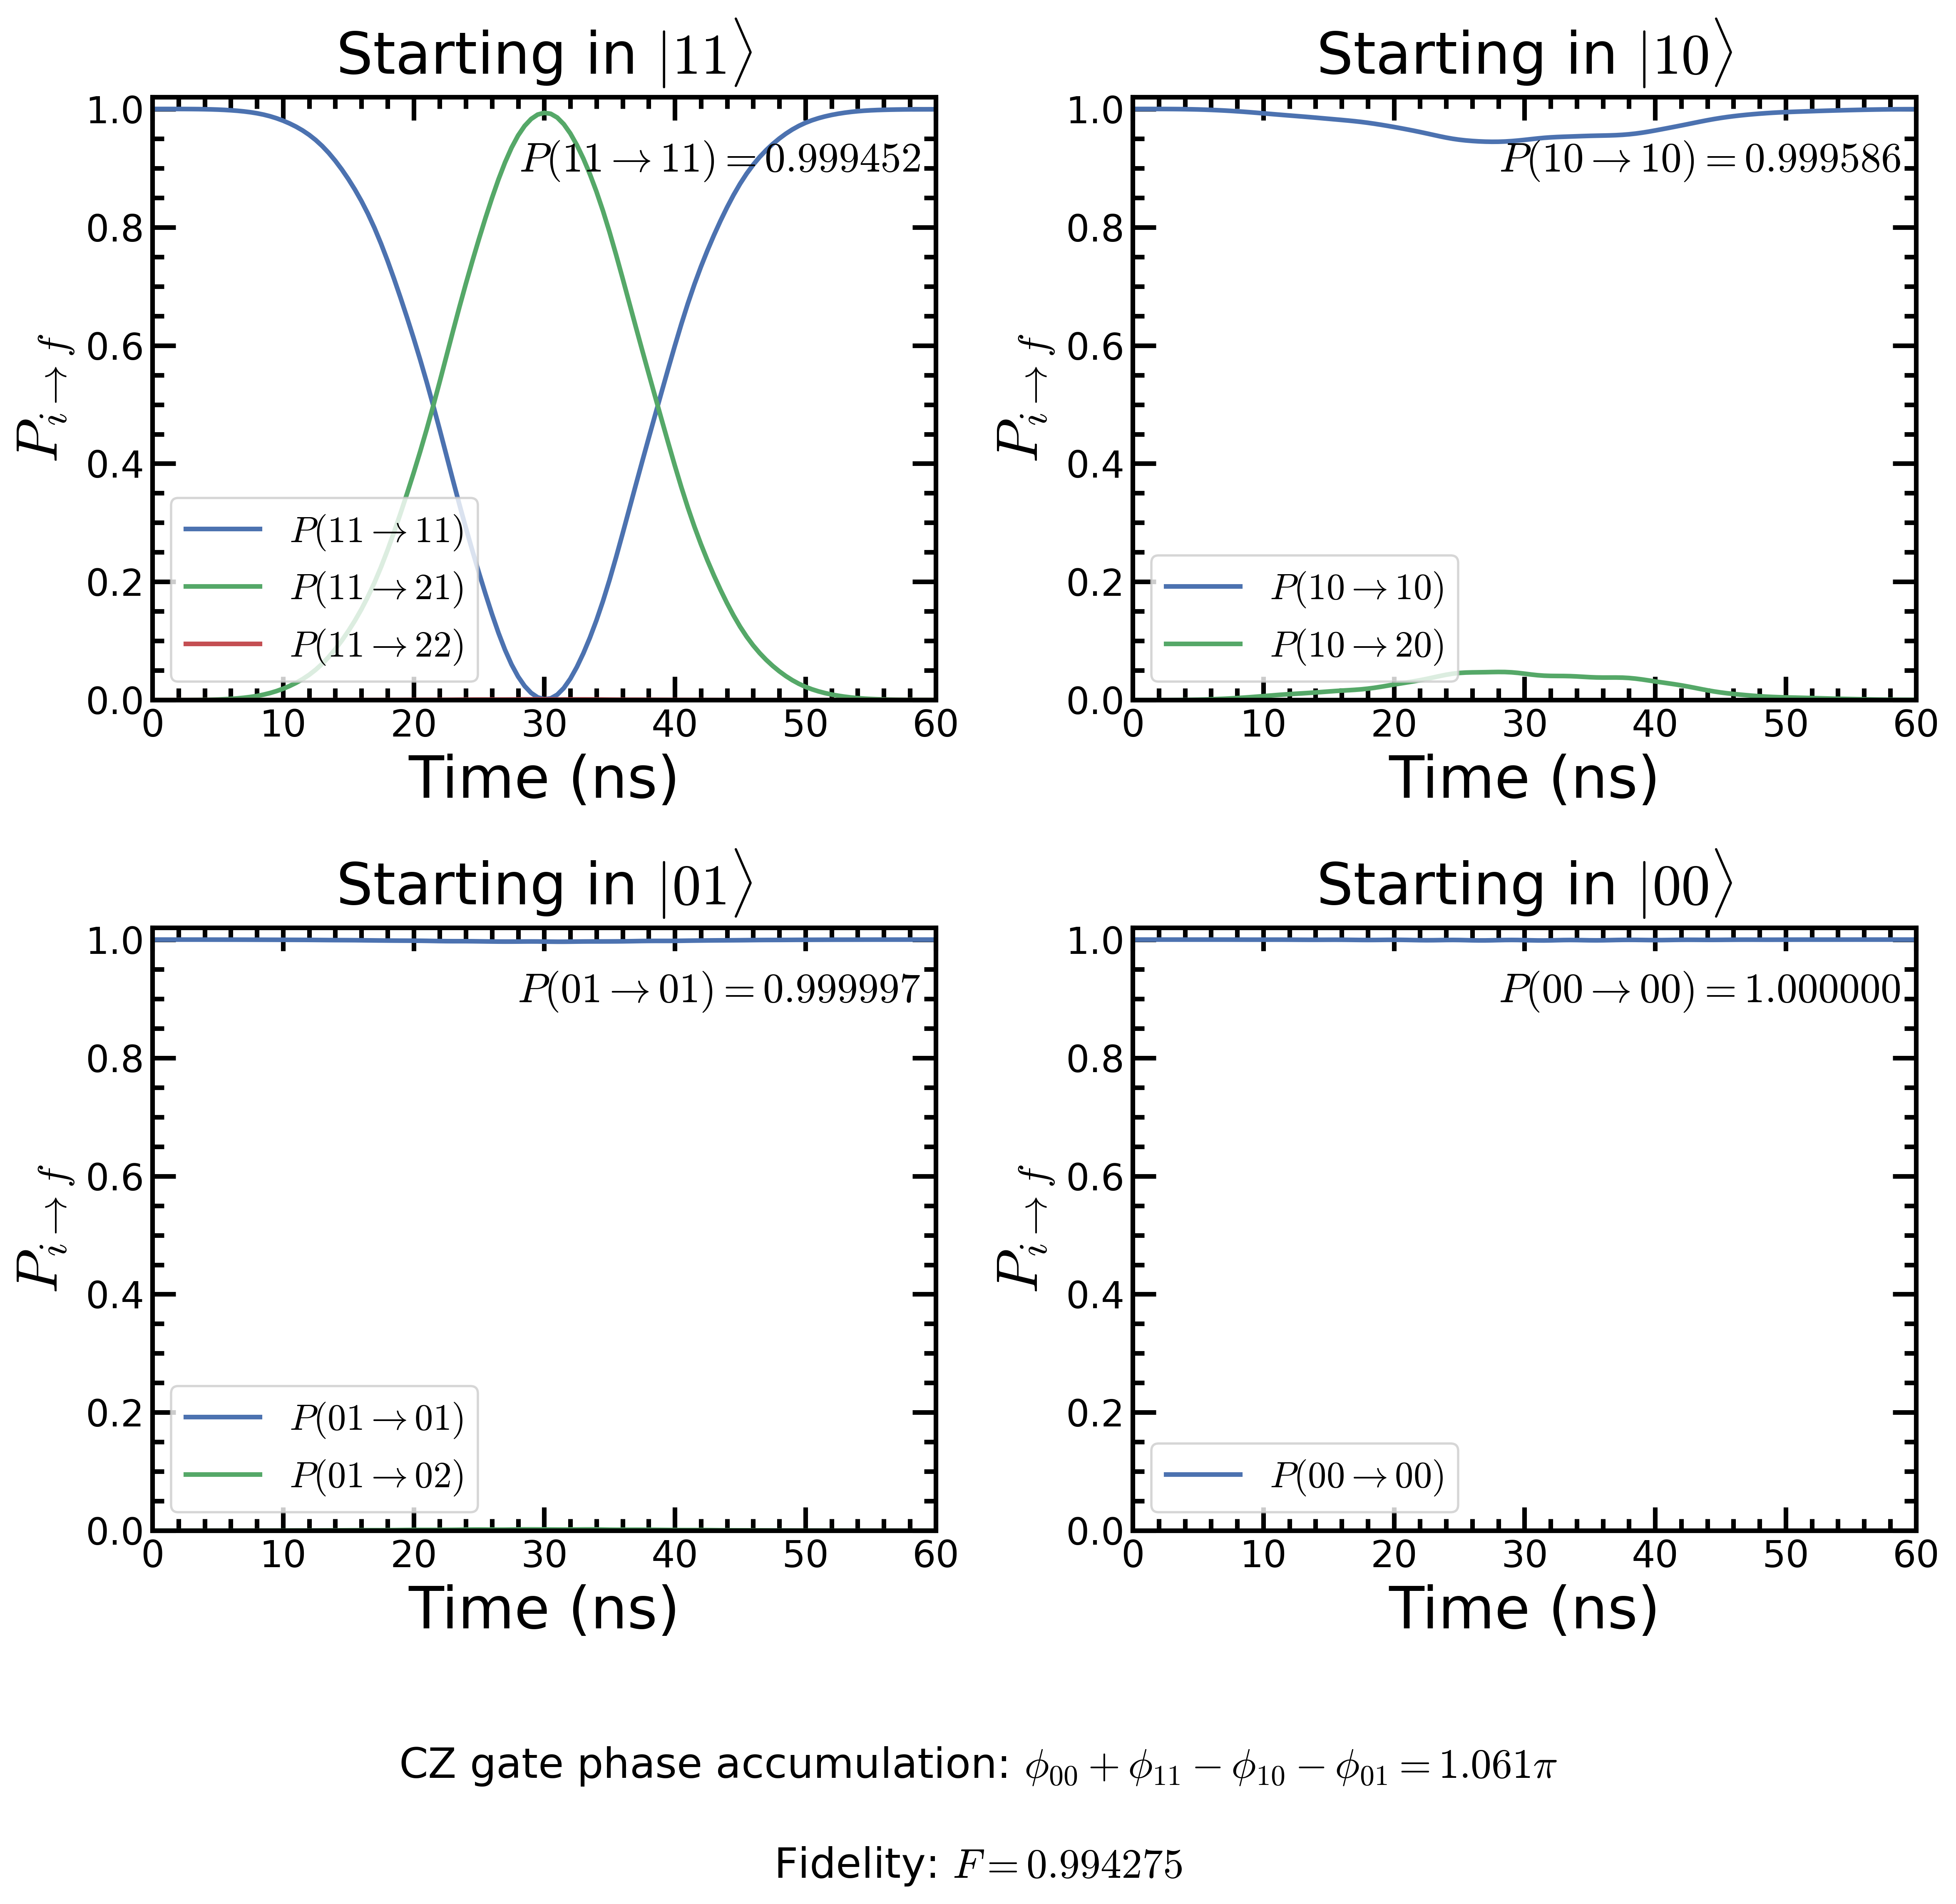

In [38]:
P011 = {}
P010 = {}
P001 = {}
P000 = {}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax011 = axes[0, 0]
ax010 = axes[0, 1]
ax001 = axes[1, 0]
ax000 = axes[1, 1]

for state in states011:
    P011[state] = evolgates.prob_transition(system, U_t, '11', state,
                                       interaction=interaction)
    ax011.plot(t_points, P011[state], lw=2,
               label=r'$P(11\rightarrow{})$'.format(state))

for state in states010:
    P010[state] = evolgates.prob_transition(
        system, U_t, '10', state, interaction=interaction)
    ax010.plot(t_points, P010[state], lw=2,
               label=r'$P(10\rightarrow {})$'.format(state))

for state in states001:
    P001[state] = evolgates.prob_transition(
        system, U_t, '01', state, interaction=interaction)
    ax001.plot(t_points, P001[state], lw=2,
               label=r'$P(01\rightarrow {})$'.format(state))

for state in states000:
    P000[state] = evolgates.prob_transition(
        system, U_t, '00', state, interaction=interaction)
    ax000.plot(t_points, P000[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))

textfontsize = 18
# fig.text(0.5, 0.3, r'At $t = {}$ ns: '.format(int(t_points[-1])),
#         fontsize=textfontsize, ha='center')
# fig.text(0.5, 0.25,
#         r'$P(11\rightarrow 11) = {:.4f}$, '.format(P011['11'][-1])
#         + r'$P(10\rightarrow 10) = {:.4f}$, '.format(P010['10'][-1])
#         + r'$P(01\rightarrow 10) = {:.4f}$, '.format(P001['01'][-1])
#         + r'$P(00\rightarrow 00) = {:.4f}$'.format(P000['00'][-1]),
#         fontsize=textfontsize, ha='center')
ax011.text(0.98, 0.93,
           r'$P(11 \rightarrow 11) = {:.6f}$'.format(P011['11'][-1]),
           ha='right', va='top', transform=ax011.transAxes,
           fontsize=textfontsize)
ax010.text(0.98, 0.93,
           r'$P(10 \rightarrow 10) = {:.6f}$'.format(P010['10'][-1]),
           ha='right', va='top', transform=ax010.transAxes,
           fontsize=textfontsize)
ax001.text(0.98, 0.93,
           r'$P(01 \rightarrow 01) = {:.6f}$'.format(P001['01'][-1]),
           ha='right', va='top', transform=ax001.transAxes,
           fontsize=textfontsize)
ax000.text(0.98, 0.93,
           r'$P(00 \rightarrow 00) = {:.6f}$'.format(P000['00'][-1]),
           ha='right', va='top', transform=ax000.transAxes,
           fontsize=textfontsize)
# fig.text(0.65, 0.25, r'$P(10) = {:.4f}$'.format(
#          P010['10'][-1]), fontsize=textfontsize)
fig.text(0.5, 0.1,
         r'CZ gate phase accumulation: '
         + '$\phi_{00} + \phi_{11} - \phi_{10} - \phi_{01} = $'
         + r'${:.3f} \pi $'.format(phase_accum),
         fontsize=textfontsize, ha='center')
fig.text(0.5, 0.05,
         r'Fidelity: '
         + r'$F = {:.6f}$'.format(fidelity[-1]),
         fontsize=textfontsize, ha='center')

for axarr in axes:
    for ax in axarr:
        ax.legend(loc='lower left')
        ax.set_xlim([np.min(t_points), np.max(t_points)])
        ax.set_xlabel('Time (ns)')
        ax.set_ylim([0, 1.02])
        ax.set_ylabel(r'$P_{i\rightarrow f}$')

ax011.set_title(
    r'Starting in $|11\rangle$')
ax010.set_title(
    r'Starting in $|10\rangle$')

ax001.set_title(
    r'Starting in $|01\rangle$')
ax000.set_title(
    r'Starting in $|00\rangle$')

fig.tight_layout(rect=[0, 0.15, 1, 1])